In [1]:
items_values = {"⚽️": 8, "💻": 47, "📸": 10, "📚": 5, "🎸": 16}
values_list = [8, 47, 10, 5, 16]

items_weight = {"⚽️": 3, "💻": 11, "📸": 14, "📚": 19, "🎸": 5}
weights_list = [3, 11, 14, 19, 5]
maximum_weight = 26

In [4]:
import numpy as np
Q = -np.diag(list(items_values.values()))  # Matrix Q for the problem above.
x_opt = np.array(
    [[1 if i in optimal_solution["items"] else 0] for i in items_values.keys()]
)  # Optimal solution.
opt_str = "".join(str(i[0]) for i in x_opt)
print(opt_str)
min_cost = (x_opt.T @ Q @ x_opt)[0, 0]  # using Equation 3 above
print(f"Q={Q}")
print(f"The minimum cost is  {min_cost}")

11001
Q=[[ -8   0   0   0   0]
 [  0 -47   0   0   0]
 [  0   0 -10   0   0]
 [  0   0   0  -5   0]
 [  0   0   0   0 -16]]
The minimum cost is  -71


In [5]:
N = round(np.ceil(np.log2(maximum_weight)))
print(N)
weights = list(items_weight.values()) + [2**k for k in range(N)]

QT = np.pad(Q, ((0, N), (0, N)))  # adding the extra slack variables at the end of the Q matrix
n_qubits = len(QT)
lambd = 2  # We choose a lambda parameter enough large for the constraint to always be fulfilled
# Adding the terms for the penalty term
for i in range(len(QT)):
    QT[i, i] += lambd * weights[i] * (weights[i] - 2 * maximum_weight)  # Eq. 10
    for j in range(i + 1, len(QT)):
        QT[i, j] += 2 * lambd * weights[i] * weights[j]  # Eq. 9
offset = lambd * maximum_weight**2
print(f"Q={QT}")
# optimal string slack string
slack_string = np.binary_repr(maximum_weight - optimal_solution["weight"], N)[::-1]
x_opt_slack = np.concatenate(
    (x_opt, np.array([[int(i)] for i in slack_string]))
)  # combining the optimal string and slack string
opt_str_slack = "".join(str(i[0]) for i in x_opt_slack)
cost = (x_opt_slack.T @ QT @ x_opt_slack)[0, 0] + offset  # Optimal cost using equation 3
print(f"Cost:{cost}")

# At this point, we have encoded the problem in a format that we can use to solve it on quantum
# computers. Now it only remains to solve it using quantum algorithms!

5
Q=[[ -302   132   168   228    60    12    24    48    96   192]
 [    0  -949   616   836   220    44    88   176   352   704]
 [    0     0 -1074  1064   280    56   112   224   448   896]
 [    0     0     0 -1259   380    76   152   304   608  1216]
 [    0     0     0     0  -486    20    40    80   160   320]
 [    0     0     0     0     0  -102     8    16    32    64]
 [    0     0     0     0     0     0  -200    32    64   128]
 [    0     0     0     0     0     0     0  -384   128   256]
 [    0     0     0     0     0     0     0     0  -704   512]
 [    0     0     0     0     0     0     0     0     0 -1152]]
Cost:-71


In [14]:
# -----------------------------   QAOA circuit ------------------------------------
from collections import defaultdict
import pennylane as qml

shots = 5000  # Number of samples used
dev = qml.device("default.qubit", shots=shots)


@qml.qnode(dev)
def qaoa_circuit(gammas, betas, h, J, num_qubits):
    wmax = max(
        np.max(np.abs(list(h.values()))), np.max(np.abs(list(h.values())))
    )  # Normalizing the Hamiltonian is a good idea
    p = len(gammas)
    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    # repeat p layers the circuit shown in Fig. 1
    for layer in range(p):
        # ---------- COST HAMILTONIAN ----------
        for ki, v in h.items():  # single-qubit terms
            qml.RZ(2 * gammas[layer] * v / wmax, wires=ki[0])
        for kij, vij in J.items():  # two-qubit terms
            qml.CNOT(wires=[kij[0], kij[1]])
            qml.RZ(2 * gammas[layer] * vij / wmax, wires=kij[1])
            qml.CNOT(wires=[kij[0], kij[1]])
        # ---------- MIXER HAMILTONIAN ----------
        for i in range(num_qubits):
            qml.RX(-2 * betas[layer], wires=i)
    return qml.sample()


def samples_dict(samples, n_items):
    """Just sorting the outputs in a dictionary"""
    results = defaultdict(int)
    for sample in samples:
        results["".join(str(i) for i in sample)[:n_items]] += 1
    return results

C:\Users\jakub\AppData\Local\Temp\ipykernel_16876\829091235.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


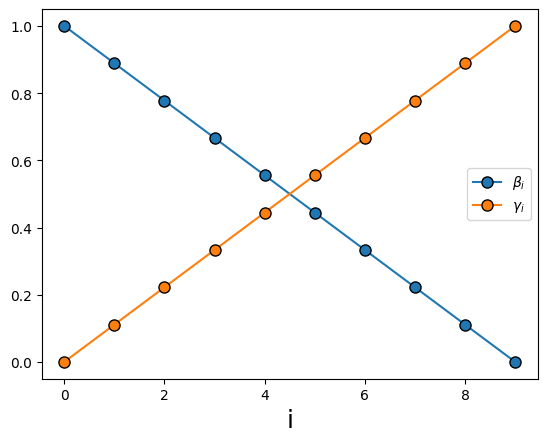

In [15]:
import matplotlib.pyplot as plt
# Annealing schedule for QAOA
betas = np.linspace(0, 1, 10)[::-1]  # Parameters for the mixer Hamiltonian
gammas = np.linspace(0, 1, 10)  # Parameters for the cost Hamiltonian (Our Knapsack problem)

fig, ax = plt.subplots()
ax.plot(betas, label=r"$\beta_i$", marker="o", markersize=8, markeredgecolor="black")
ax.plot(gammas, label=r"$\gamma_i$", marker="o", markersize=8, markeredgecolor="black")
ax.set_xlabel("i", fontsize=18)
ax.legend()
fig.show()

In [16]:
def from_Q_to_Ising(Q, offset):
    """Convert the matrix Q of Eq.3 into Eq.13 elements J and h"""
    n_qubits = len(Q)  # Get the number of qubits (variables) in the QUBO matrix
    # Create default dictionaries to store h and pairwise interactions J
    h = defaultdict(int)
    J = defaultdict(int)

    # Loop over each qubit (variable) in the QUBO matrix
    for i in range(n_qubits):
        # Update the magnetic field for qubit i based on its diagonal element in Q
        h[(i,)] -= Q[i, i] / 2
        # Update the offset based on the diagonal element in Q
        offset += Q[i, i] / 2
        # Loop over other qubits (variables) to calculate pairwise interactions
        for j in range(i + 1, n_qubits):
            # Update the pairwise interaction strength (J) between qubits i and j
            J[(i, j)] += Q[i, j] / 4
            # Update the magnetic fields for qubits i and j based on their interactions in Q
            h[(i,)] -= Q[i, j] / 4
            h[(j,)] -= Q[i, j] / 4
            # Update the offset based on the interaction strength between qubits i and j
            offset += Q[i, j] / 4
    # Return the magnetic fields, pairwise interactions, and the updated offset
    return h, J, offset


def energy_Ising(z, h, J, offset):
    """
    Calculate the energy of an Ising model given spin configurations.

    Parameters:
    - z: A dictionary representing the spin configurations for each qubit.
    - h: A dictionary representing the magnetic fields for each qubit.
    - J: A dictionary representing the pairwise interactions between qubits.
    - offset: An offset value.

    Returns:
    - energy: The total energy of the Ising model.
    """
    if isinstance(z, str):
        z = [(1 if int(i) == 0 else -1) for i in z]
    # Initialize the energy with the offset term
    energy = offset
    # Loop over the magnetic fields (h) for each qubit and update the energy
    for k, v in h.items():
        energy += v * z[k[0]]
    # Loop over the pairwise interactions (J) between qubits and update the energy
    for k, v in J.items():
        energy += v * z[k[0]] * z[k[1]]
    # Return the total energy of the Ising model
    return energy


# Our previous example should give us the same result
z_exp = [
    (1 if i == 0 else -1) for i in x_opt_slack
]  # Converting the optimal solution from (0,1) to (1, -1)
h, J, zoffset = from_Q_to_Ising(QT, offset)  # Eq.13 for our problem
energy = energy_Ising(
    z_exp, h, J, zoffset
)  # Caluclating the energy (Should be the same that for the QUBO)
print(f"Minimum energy:{energy}")

samples_slack = samples_dict(qaoa_circuit(gammas, betas, h, J, num_qubits=len(QT)), n_qubits)
values_slack = {
    sum_values(sample_i, values_list): count
    for sample_i, count in samples_slack.items()
    if sum_weight(sample_i, weights_list) <= maximum_weight
}  # saving only the solutions that fulfill the constraint
print(
    f"The number of optimal solutions using slack variables is {samples_slack[opt_str_slack]} out of {shots}"
)

Minimum energy:-71.0
The number of optimal solutions using slack variables is 19 out of 5000


In [17]:
from openqaoa.problems import FromDocplex2IsingModel
from docplex.mp.model import Model


def Knapsack(values, weights, maximum_weight):
    """Create a docplex model of the problem. (Docplex is a classical solver from IBM)"""
    n_items = len(values)
    mdl = Model()
    x = mdl.binary_var_list(range(n_items), name="x")
    cost = -mdl.sum(x[i] * values[i] for i in range(n_items))
    mdl.minimize(cost)
    mdl.add_constraint(mdl.sum(x[i] * weights[i] for i in range(n_items)) <= maximum_weight)
    return mdl


# Docplex model, we need to convert our problem in this format to use the unbalanced penalization approach
mdl = Knapsack(values_list, weights_list, maximum_weight)
lambda_1, lambda_2 = (
    0.96,
    0.0371,
)  # Parameters of the unbalanced penalization function (They are in the main paper)
ising_hamiltonian = FromDocplex2IsingModel(
    mdl,
    unbalanced_const=True,
    strength_ineq=[lambda_1, lambda_2],  # https://arxiv.org/abs/2211.13914
).ising_model

h_new = {
    tuple(i): w for i, w in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if len(i) == 1
}
J_new = {
    tuple(i): w for i, w in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if len(i) == 2
}

samples_unbalanced = samples_dict(
    qaoa_circuit(gammas, betas, h_new, J_new, num_qubits=n_items), n_items
)
values_unbalanced = {
    sum_values(sample_i, values_list): count
    for sample_i, count in samples_unbalanced.items()
    if sum_weight(sample_i, weights_list) <= maximum_weight
}  # saving only the solutions that fulfill the constraint

print(
    f"The number of solutions using unbalanced penalization is {samples_unbalanced[opt_str]} out of {shots}"
)

ModuleNotFoundError: No module named 'openqaoa'

NameError: name 'values_unbalanced' is not defined

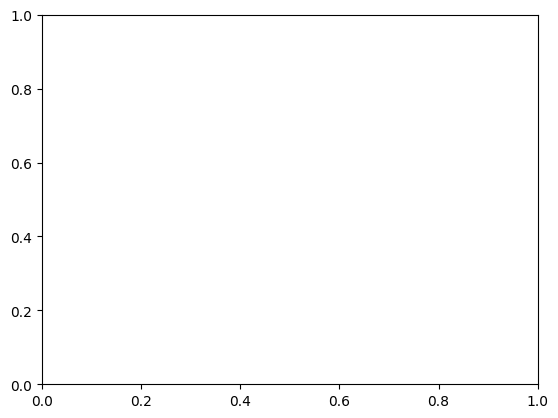

In [11]:
fig, ax = plt.subplots()
ax.hist(
    values_unbalanced.keys(),
    weights=values_unbalanced.values(),
    bins=50,
    edgecolor="black",
    label="unbalanced",
    align="right",
)
ax.hist(
    values_slack.keys(),
    weights=values_slack.values(),
    bins=50,
    edgecolor="black",
    label="slack",
    align="left",
)
ax.vlines(-min_cost, 0, 3000, linestyle="--", color="black", label="Optimal", linewidth=2)
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("counts")
ax.set_xlabel("values")
fig.show()

In [12]:
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client
import dimod
import pandas as pd

bqm = {}
# BQM - Binary Quadratic Model
# This creates the QUBO model of our Knapsack problem using the slack variables approach
# offset is the constant term in our QUBO formulation
# ----------- SLACK METHOD -----------
bqm["slack"] = dimod.BQM.from_qubo(QT, offset=lambd * maximum_weight**2)
bqm["slack"].relabel_variables({i: f"x_{i}" for i in range(bqm["slack"].num_variables)})
# -----------  UNBALANCED METHOD -----------
lagrange_multiplier = [0.96, 0.0371]  # Again values from the paper
bqm["unbalanced"] = dimod.BQM.from_qubo(Q)  # This adds the objective function to the model
bqm["unbalanced"].add_linear_inequality_constraint(
    [(n, i) for n, i in enumerate(weights_list)],  # This adds the constraint
    lagrange_multiplier,
    "unbalanced",
    ub=maximum_weight,
    penalization_method="unbalanced",
)
bqm["unbalanced"].relabel_variables({i: f"x_{i}" for i in range(bqm["unbalanced"].num_variables)})

# If you have an account you can execute the following code, otherwise read the file.
account = False
df = {}
if account:
    # Replace with your client information
    sampler = DWaveSampler(region="eu-central-1")
    sampler_qpu = EmbeddingComposite(sampler)
    for method in ["slack", "unbalanced"]:
        samples = sampler_qpu.sample(bqm[method], num_reads=5000)  # Executing on real hardware
        df[method] = (
            samples.to_pandas_dataframe().sort_values("energy").reset_index(drop=True)
        )  # Converting the sampling information and sort it by cost
        df[method].to_json(f"QUBO/dwave_results_{method}.json")  # save the results
else:
    df = {}
    for method in ["slack", "unbalanced"]:
        df[method] = pd.read_json(f"QUBO/dwave_results_{method}.json")
        # Loading the data from an execution on D-Wave Advantage


samples_dwave = {}
values = {}
for method in ["slack", "unbalanced"]:
    samples_dwave[method] = defaultdict(int)
    for i, row in df[method].iterrows():
        # Postprocessing the information
        sample_i = "".join(str(round(row[q])) for q in bqm[method].variables)
        samples_dwave[method][sample_i] += row["num_occurrences"]
    values[method] = {
        sum_values(sample_i, values_list): count
        for sample_i, count in samples_dwave[method].items()
        if sum_weight(sample_i, weights_list) <= maximum_weight
    }

ModuleNotFoundError: No module named 'dwave'

NameError: name 'values' is not defined

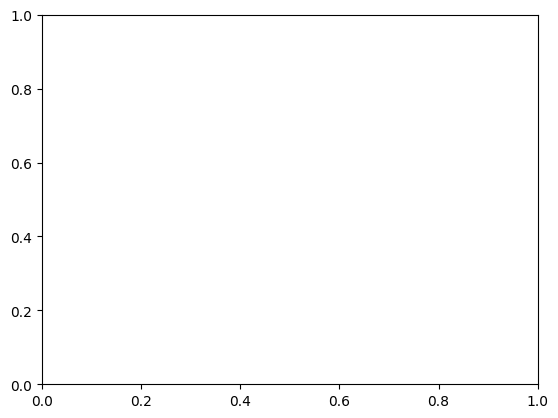

In [13]:
fig, ax = plt.subplots()
bins = {"unbalanced": 5, "slack": 40}
for method in ["unbalanced", "slack"]:
    ax.hist(
        values[method].keys(),
        weights=values[method].values(),
        bins=bins[method],
        edgecolor="black",
        label=method,
        align="right",
    )
ax.vlines(-min_cost, 0, 5000, linestyle="--", color="black", label="Optimal", linewidth=2)
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("counts")
ax.set_xlabel("value")
fig.show()

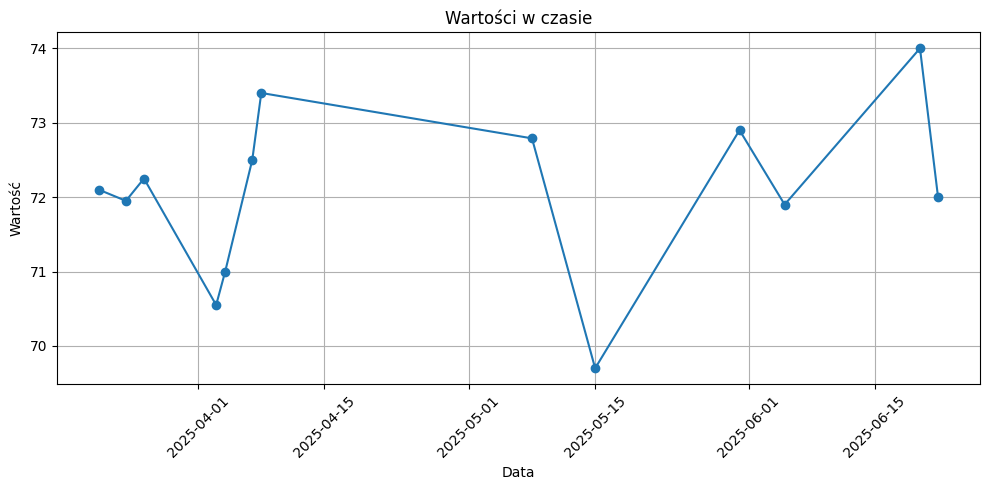

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Dane
data = {
    "date": [
        "21.03.2025", "24.03.2025", "26.03.2025", "03.04.2025", "04.04.2025",
        "07.04.2025", "08.04.2025", "08.05.2025", "15.05.2025", "31.05.2025",
        "05.06.2025", "20.06.2025", "22.06.2025"
    ],
    "value": [
        72.1, 71.95, 72.25, 70.55, 71, 72.5, 73.4, 72.79, 69.7,
        72.9, 71.9, 74, 72
    ]
}

# Tworzenie DataFrame i konwersja dat
df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")

# Sortowanie dat (na wszelki wypadek)
df = df.sort_values("date")

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["value"], marker='o', linestyle='-')
plt.title("Wartości w czasie")
plt.xlabel("Data")
plt.ylabel("Wartość")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [1]:
import sympy as sp

L = range(3)
M = range(2)
P1 = sp.symbols('P1')

x = sp.Matrix([[sp.symbols(f'x_{i+1}{n+1}') for n in M] for i in L])

penalty = 0
for n in M:
    expr = sum(x[i, n] for i in L) - 1
    penalty += P1 * expr**2

print(sp.expand(penalty))

P1*x_11**2 + 2*P1*x_11*x_21 + 2*P1*x_11*x_31 - 2*P1*x_11 + P1*x_12**2 + 2*P1*x_12*x_22 + 2*P1*x_12*x_32 - 2*P1*x_12 + P1*x_21**2 + 2*P1*x_21*x_31 - 2*P1*x_21 + P1*x_22**2 + 2*P1*x_22*x_32 - 2*P1*x_22 + P1*x_31**2 - 2*P1*x_31 + P1*x_32**2 - 2*P1*x_32 + 2*P1


In [2]:
import sympy as sp

l, m = 3, 4  # liczby lokalizacji i mieszkańców
x = sp.Matrix([[sp.Symbol(f'x_{i}_{n}', integer=True) for n in range(m)] for i in range(l)])

r = sp.Matrix([[sp.Symbol(f'r_{i}_{n}') for n in range(m)] for i in range(l)])
c = sp.Matrix([sp.Symbol(f'c_{i}') for i in range(l)])

# Wyrażenie celu
objective = sum(r[i, n] * x[i, n] + c[i] * x[i, n] for i in range(l) for n in range(m))
objective = sp.expand(objective)
objective

c_0*x_0_0 + c_0*x_0_1 + c_0*x_0_2 + c_0*x_0_3 + c_1*x_1_0 + c_1*x_1_1 + c_1*x_1_2 + c_1*x_1_3 + c_2*x_2_0 + c_2*x_2_1 + c_2*x_2_2 + c_2*x_2_3 + r_0_0*x_0_0 + r_0_1*x_0_1 + r_0_2*x_0_2 + r_0_3*x_0_3 + r_1_0*x_1_0 + r_1_1*x_1_1 + r_1_2*x_1_2 + r_1_3*x_1_3 + r_2_0*x_2_0 + r_2_1*x_2_1 + r_2_2*x_2_2 + r_2_3*x_2_3